Pip install's for remote GPU

In [9]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install torchmetrics
!pip install torchinfo
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install pytorch-toolbelt
!pip install segmentation-models-pytorch

Imports

In [10]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torchvision import *
from torchvision import datasets

from torchmetrics import *
from torchmetrics import JaccardIndex
from torchmetrics import Dice

from torch.utils.data import *

import sklearn as sk
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn import *
from sklearn import svm
from sklearn.metrics import jaccard_score
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io, color

import segmentation_models_pytorch as smp

from PIL import Image

import pandas as pd

from itertools import compress

from tqdm import tqdm

from dataset import PolypsSegmentationDataset

Data Processing

In [11]:
# define path to images
image_path = './Kvasir-SEG'
size = 256
# get dataset, need resize to be divisible by 16 for all 4 max pools, to keep 
# dim the same of up transpose
# need tot check resize to see if random crop is correct
# and check to normalize
dataset = PolypsSegmentationDataset(image_path,size)
augmented_dataset = PolypsSegmentationDataset(image_path,size,True)

100%|██████████| 1000/1000 [00:00<00:00, 360645.23it/s]


In [12]:
# hyperparameters
BATCH_SIZE = 16
# converting dataset to dataloader, why does shuffle cause error?
# dataloader = DataLoader(dataset = dataset, batch_size = BATCH_SIZE)

Network

In [13]:
# loading unet model from pytorch
UNet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=64, pretrained=False)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Training Methods

In [14]:
# Define the training function
def train(model, loss_fn, device, train_loader, optimizer, jaccard, dice):
    
    total_loss = 0
    total_iou = 0
    total_dice = 0
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        # get x and y
        X_train, y_train = X.to(device), y.to(device)
        model.train()
        # get output
        output = model(X_train).to(device)
        # compute loss
        loss = loss_fn(output, y_train)
        total_loss += loss.item()
        # compute IOU
        iou = jaccard(torch.where(output > 0.5, 1, 0),torch.where(y_train > 0.50, 1, 0))
        total_iou += iou
        # compute dice score
        dice_score = dice(torch.where(output > 0.5, 1, 0),torch.where(y_train > 0.50, 1, 0))
        total_dice += dice_score
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Train Loss: {total_loss / len(train_loader)} | Train IOU: {total_iou / len(train_loader)} | Train Dice: {total_dice / len(train_loader)}")
        

Training

In [15]:
# number of splits for data
splits = 10
# defining k-fold object
kf = KFold(splits,shuffle = True)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
model = UNet.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
loss = torch.nn.BCELoss()
jaccard = JaccardIndex(task= 'BINARY',num_classes = 1, threshold = 0.5).to(device)
dice = Dice(average = 'micro', num_classes = 2, threshold = 0.5).to(device)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)


Binary Cross Entropy Loss

In [73]:

torch.cuda.empty_cache()

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold: {fold + 1}")
    # get test loader
    train_loader = DataLoader(
        dataset=augmented_dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        )
    # get train loader
    test_loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )
    #Train Model
    for i in range(5):
        train(model, loss, device, train_loader, optimizer, jaccard, dice)
    
    #Decays learning rate after each kfold
    lr_scheduler.step()
    
    #Evaluate model
    model.eval()
    test_loss = 0
    test_IOU = 0
    test_dice = 0
    with torch.inference_mode():
        for X, y in tqdm(test_loader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += loss(output, y).item()
            test_IOU += jaccard(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(test_loader)
    test_IOU /= len(test_loader)
    test_dice /= len(test_loader)
    print(f"Test set Average loss: {test_loss} | IOU: {test_IOU} | Dice: {test_dice}")
    

Fold: 1
Train Loss: 0.3246012523508908 | Train IOU: 0.22953636944293976 | Train Dice: 0.8555375933647156
Train Loss: 0.3173249722049947 | Train IOU: 0.2630769610404968 | Train Dice: 0.8597924113273621
Train Loss: 0.3110210547844569 | Train IOU: 0.28802385926246643 | Train Dice: 0.8635881543159485
Train Loss: 0.3119384981038278 | Train IOU: 0.287295401096344 | Train Dice: 0.8640230298042297
Train Loss: 0.3019134572200608 | Train IOU: 0.317396879196167 | Train Dice: 0.8685218095779419


100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


Test set Average loss: 0.29844591447285246 | IOU: 0.18376511761120387 | Dice: 0.8731892449515206
Fold: 2
Train Loss: 0.29432114932620734 | Train IOU: 0.27370908856391907 | Train Dice: 0.8732500672340393
Train Loss: 0.2865501610856307 | Train IOU: 0.3297019302845001 | Train Dice: 0.8765408992767334
Train Loss: 0.28557975250377987 | Train IOU: 0.33532485365867615 | Train Dice: 0.8768834471702576
Train Loss: 0.2854928742898138 | Train IOU: 0.3337458372116089 | Train Dice: 0.8777523636817932
Train Loss: 0.28472888495838433 | Train IOU: 0.33675616979599 | Train Dice: 0.8776412606239319


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Test set Average loss: 0.3199853811945234 | IOU: 0.3607363360268729 | Dice: 0.8580853598458427
Fold: 3
Train Loss: 0.28122893446370173 | Train IOU: 0.3538222014904022 | Train Dice: 0.8802264332771301
Train Loss: 0.2838909631235558 | Train IOU: 0.3479730188846588 | Train Dice: 0.8776221871376038
Train Loss: 0.2834571236581133 | Train IOU: 0.3529863953590393 | Train Dice: 0.8783853650093079
Train Loss: 0.280654731026867 | Train IOU: 0.356536328792572 | Train Dice: 0.8798822164535522
Train Loss: 0.28503276277006717 | Train IOU: 0.3584207594394684 | Train Dice: 0.878139078617096


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Test set Average loss: 0.299784426178251 | IOU: 0.2491137268287795 | Dice: 0.8709449768066406
Fold: 4
Train Loss: 0.2860744080522604 | Train IOU: 0.3517204523086548 | Train Dice: 0.8766312003135681
Train Loss: 0.280644029378891 | Train IOU: 0.3530982434749603 | Train Dice: 0.8789738416671753
Train Loss: 0.2842458486557007 | Train IOU: 0.3512399196624756 | Train Dice: 0.8776099681854248
Train Loss: 0.28118475722639186 | Train IOU: 0.35958337783813477 | Train Dice: 0.8804478049278259
Train Loss: 0.28220231752646596 | Train IOU: 0.3480183184146881 | Train Dice: 0.8791677951812744


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Test set Average loss: 0.3188244679144451 | IOU: 0.3482488287346704 | Dice: 0.8656800133841378
Fold: 5
Train Loss: 0.29205829166529473 | Train IOU: 0.34376585483551025 | Train Dice: 0.8741167783737183
Train Loss: 0.2880961824404566 | Train IOU: 0.34325483441352844 | Train Dice: 0.8757225871086121
Train Loss: 0.286719621796357 | Train IOU: 0.34316951036453247 | Train Dice: 0.8756811618804932
Train Loss: 0.28596063847081704 | Train IOU: 0.3500840365886688 | Train Dice: 0.876876711845398
Train Loss: 0.2872100922099331 | Train IOU: 0.34767064452171326 | Train Dice: 0.8763291239738464


100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


Test set Average loss: 0.25819943845272064 | IOU: 0.40388159666742596 | Dice: 0.8932597296578544
Fold: 6
Train Loss: 0.2861002529399437 | Train IOU: 0.3446207046508789 | Train Dice: 0.876017689704895
Train Loss: 0.2840150772479543 | Train IOU: 0.3520493805408478 | Train Dice: 0.8776971101760864
Train Loss: 0.2889698124245593 | Train IOU: 0.3450757563114166 | Train Dice: 0.8747583031654358
Train Loss: 0.286322915240338 | Train IOU: 0.34762904047966003 | Train Dice: 0.8764713406562805
Train Loss: 0.28625924519279544 | Train IOU: 0.3475101888179779 | Train Dice: 0.876926839351654


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Test set Average loss: 0.2720533332654408 | IOU: 0.3629371566431863 | Dice: 0.8844119480678013
Fold: 7
Train Loss: 0.28330726503280174 | Train IOU: 0.35712507367134094 | Train Dice: 0.8792029619216919
Train Loss: 0.2854264603372206 | Train IOU: 0.34973254799842834 | Train Dice: 0.8768491744995117
Train Loss: 0.28403974834241363 | Train IOU: 0.3493104577064514 | Train Dice: 0.8778063654899597
Train Loss: 0.2856305487323226 | Train IOU: 0.34461110830307007 | Train Dice: 0.8763285875320435
Train Loss: 0.2836532218937288 | Train IOU: 0.3527735471725464 | Train Dice: 0.8788518309593201


100%|██████████| 7/7 [00:06<00:00,  1.02it/s]


Test set Average loss: 0.283402966601508 | IOU: 0.36192743267331806 | Dice: 0.8753222056797573
Fold: 8
Train Loss: 0.2841543285993108 | Train IOU: 0.3523366153240204 | Train Dice: 0.8776745200157166
Train Loss: 0.28325914839903515 | Train IOU: 0.3520902395248413 | Train Dice: 0.8784652352333069
Train Loss: 0.2847041103400682 | Train IOU: 0.348817378282547 | Train Dice: 0.8771900534629822
Train Loss: 0.28472156535115156 | Train IOU: 0.35034868121147156 | Train Dice: 0.8781469464302063
Train Loss: 0.2826633733092693 | Train IOU: 0.3502822816371918 | Train Dice: 0.8783833980560303


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Test set Average loss: 0.2736365113939558 | IOU: 0.3141621776989528 | Dice: 0.8869378226143974
Fold: 9
Train Loss: 0.2836915853253582 | Train IOU: 0.34979870915412903 | Train Dice: 0.8780457973480225
Train Loss: 0.28390820664271976 | Train IOU: 0.3494858741760254 | Train Dice: 0.8776386976242065
Train Loss: 0.28597867619573025 | Train IOU: 0.3473689556121826 | Train Dice: 0.8773207068443298
Train Loss: 0.2841184100038127 | Train IOU: 0.34807485342025757 | Train Dice: 0.8780869841575623
Train Loss: 0.28318118369370177 | Train IOU: 0.34833115339279175 | Train Dice: 0.8781545758247375


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


Test set Average loss: 0.27979118270533426 | IOU: 0.31771701148578096 | Dice: 0.8790710994175502
Fold: 10
Train Loss: 0.2845180115678854 | Train IOU: 0.3465556204319 | Train Dice: 0.8775067329406738
Train Loss: 0.2855563788560399 | Train IOU: 0.35219481587409973 | Train Dice: 0.8774243593215942
Train Loss: 0.2839584047334236 | Train IOU: 0.3507448434829712 | Train Dice: 0.878163754940033
Train Loss: 0.2843853452226572 | Train IOU: 0.3511730134487152 | Train Dice: 0.8777517676353455
Train Loss: 0.2853232345037293 | Train IOU: 0.34722864627838135 | Train Dice: 0.8766123056411743


100%|██████████| 7/7 [00:07<00:00,  1.14s/it]

Test set Average loss: 0.2658813957657133 | IOU: 0.3639284244605473 | Dice: 0.8867652075631278


Data Augmentation

In [17]:
loss = torch.nn.BCELoss()

In [19]:
torch.cuda.empty_cache()

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"Fold: {fold + 1}")
    # get test loader
    train_loader = DataLoader(
        dataset=augmented_dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx)
        )
    # get train loader
    test_loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )
    #Train Model
    for i in range(5):
        train(model, loss, device, train_loader, optimizer, jaccard, dice)
    
    #Decays learning rate after each kfold
    lr_scheduler.step()
    
    #Evaluate model
    model.eval()
    test_loss = 0
    test_IOU = 0
    test_dice = 0
    with torch.inference_mode():
        for X, y in tqdm(test_loader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += loss(output, y).item()
            test_IOU += jaccard(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(test_loader)
    test_IOU /= len(test_loader)
    test_dice /= len(test_loader)
    print(f"Test set Average loss: {test_loss} | IOU: {test_IOU} | Dice: {test_dice}")

Fold: 1
Train Loss: 0.38629110340486494 | Train IOU: 0.06416987627744675 | Train Dice: 0.8428726196289062
Train Loss: 0.3383284404612424 | Train IOU: 0.09211471676826477 | Train Dice: 0.8475379347801208
Train Loss: 0.3276794516203696 | Train IOU: 0.10796163231134415 | Train Dice: 0.8500115871429443
Train Loss: 0.30798986815569696 | Train IOU: 0.257480263710022 | Train Dice: 0.8609015941619873
Train Loss: 0.301526569483573 | Train IOU: 0.2932197153568268 | Train Dice: 0.8655009865760803


100%|██████████| 7/7 [00:07<00:00,  1.01s/it]


Test set Average loss: 0.3627829466547285 | IOU: 0.18875228400741303 | Dice: 0.8309416089739118
Fold: 2
Train Loss: 0.29365150081483943 | Train IOU: 0.291400671005249 | Train Dice: 0.8702702522277832
Train Loss: 0.284516556482566 | Train IOU: 0.32536235451698303 | Train Dice: 0.8756483197212219
Train Loss: 0.2820563622211155 | Train IOU: 0.3495596647262573 | Train Dice: 0.8773300647735596
Train Loss: 0.2790564889447731 | Train IOU: 0.3604278266429901 | Train Dice: 0.879483699798584
Train Loss: 0.27782066114116133 | Train IOU: 0.3657207190990448 | Train Dice: 0.8798471093177795


100%|██████████| 7/7 [00:09<00:00,  1.42s/it]


Test set Average loss: 0.3016202471085957 | IOU: 0.37554243206977844 | Dice: 0.8669665200369698
Fold: 3
Train Loss: 0.27763889703834266 | Train IOU: 0.3701327443122864 | Train Dice: 0.8815921545028687
Train Loss: 0.27639121549171314 | Train IOU: 0.37554892897605896 | Train Dice: 0.8806297779083252
Train Loss: 0.27316750115469884 | Train IOU: 0.3816166818141937 | Train Dice: 0.8827662467956543
Train Loss: 0.27395132471594896 | Train IOU: 0.3858667314052582 | Train Dice: 0.8822600245475769
Train Loss: 0.27294176581658813 | Train IOU: 0.38179630041122437 | Train Dice: 0.8826286196708679


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Test set Average loss: 0.27959818073681425 | IOU: 0.41636099985667635 | Dice: 0.8775382723127093
Fold: 4
Train Loss: 0.27227085541214857 | Train IOU: 0.380340576171875 | Train Dice: 0.8826198577880859
Train Loss: 0.2725303810939454 | Train IOU: 0.3822510838508606 | Train Dice: 0.8826766610145569
Train Loss: 0.27356503093451784 | Train IOU: 0.38286346197128296 | Train Dice: 0.8824284076690674
Train Loss: 0.27221810321013135 | Train IOU: 0.3863668739795685 | Train Dice: 0.8831830620765686
Train Loss: 0.2738532254047561 | Train IOU: 0.3834488093852997 | Train Dice: 0.8821937441825867


100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Test set Average loss: 0.27132705066885265 | IOU: 0.4020748862198421 | Dice: 0.8820596422467913
Fold: 5
Train Loss: 0.27138417174941615 | Train IOU: 0.3841342329978943 | Train Dice: 0.8834658861160278
Train Loss: 0.2757853755825444 | Train IOU: 0.3728063106536865 | Train Dice: 0.88093101978302
Train Loss: 0.2718079769820498 | Train IOU: 0.38011035323143005 | Train Dice: 0.8831321597099304
Train Loss: 0.27268944053273453 | Train IOU: 0.38332584500312805 | Train Dice: 0.8826606273651123
Train Loss: 0.27409205520362184 | Train IOU: 0.379260390996933 | Train Dice: 0.8822095990180969


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


Test set Average loss: 0.26506890782288145 | IOU: 0.46969624928065706 | Dice: 0.8874939509800502
Fold: 6
Train Loss: 0.27128253824878157 | Train IOU: 0.38518497347831726 | Train Dice: 0.8838115334510803
Train Loss: 0.27785480492993403 | Train IOU: 0.37856096029281616 | Train Dice: 0.8807684779167175
Train Loss: 0.27476927455057176 | Train IOU: 0.37776628136634827 | Train Dice: 0.8821098208427429
Train Loss: 0.2720282760105635 | Train IOU: 0.3853963017463684 | Train Dice: 0.8837186694145203
Train Loss: 0.2714582841124451 | Train IOU: 0.3859442472457886 | Train Dice: 0.8843171000480652


100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


Test set Average loss: 0.27222813240119387 | IOU: 0.40721667238644194 | Dice: 0.8767539433070591
Fold: 7
Train Loss: 0.2715461335161276 | Train IOU: 0.37834951281547546 | Train Dice: 0.8822835087776184
Train Loss: 0.2705771862937693 | Train IOU: 0.38084059953689575 | Train Dice: 0.8833017349243164
Train Loss: 0.26945045485831143 | Train IOU: 0.38725486397743225 | Train Dice: 0.8848113417625427
Train Loss: 0.2718081971009572 | Train IOU: 0.37920263409614563 | Train Dice: 0.8829035758972168
Train Loss: 0.27024106890486 | Train IOU: 0.3831268548965454 | Train Dice: 0.8838162422180176


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Test set Average loss: 0.29967394896915983 | IOU: 0.45591833761760164 | Dice: 0.8721271242414202
Fold: 8
Train Loss: 0.2712529623194745 | Train IOU: 0.3901199698448181 | Train Dice: 0.8846302032470703
Train Loss: 0.27406418977076547 | Train IOU: 0.3823392391204834 | Train Dice: 0.8817262649536133
Train Loss: 0.27469886107402935 | Train IOU: 0.38568824529647827 | Train Dice: 0.8822749257087708
Train Loss: 0.2742906735654463 | Train IOU: 0.3804031312465668 | Train Dice: 0.8818307518959045
Train Loss: 0.2770696075861914 | Train IOU: 0.3784743845462799 | Train Dice: 0.8810383081436157


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Test set Average loss: 0.27864787195410046 | IOU: 0.4144444337912968 | Dice: 0.8784251894269671
Fold: 9
Train Loss: 0.27517380604618474 | Train IOU: 0.3806667625904083 | Train Dice: 0.8818724155426025
Train Loss: 0.27189009336003084 | Train IOU: 0.3796652853488922 | Train Dice: 0.8828878402709961
Train Loss: 0.2727722860219186 | Train IOU: 0.38105419278144836 | Train Dice: 0.8826588988304138
Train Loss: 0.2736228701838276 | Train IOU: 0.38176316022872925 | Train Dice: 0.8822314739227295
Train Loss: 0.27613054451189545 | Train IOU: 0.3842284679412842 | Train Dice: 0.881344199180603


100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


Test set Average loss: 0.2747173479625157 | IOU: 0.4271509775093624 | Dice: 0.880335807800293
Fold: 10
Train Loss: 0.27546615349619014 | Train IOU: 0.38390353322029114 | Train Dice: 0.8815337419509888
Train Loss: 0.2736168085483083 | Train IOU: 0.3869211971759796 | Train Dice: 0.8827494382858276
Train Loss: 0.27753261359114395 | Train IOU: 0.37873217463493347 | Train Dice: 0.880262553691864
Train Loss: 0.2751583608618954 | Train IOU: 0.3832845091819763 | Train Dice: 0.8818897008895874
Train Loss: 0.2796055745137365 | Train IOU: 0.3804454803466797 | Train Dice: 0.8802502751350403


100%|██████████| 7/7 [00:08<00:00,  1.23s/it]

Test set Average loss: 0.26345946320465635 | IOU: 0.39206341547625406 | Dice: 0.8833623613630023


Testing

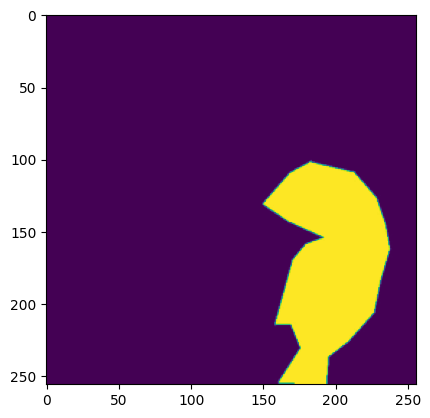

In [11]:
plt.imshow(y[3].cpu().permute(1,2,0))

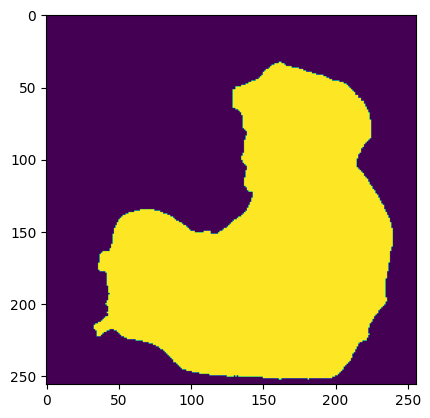

In [12]:
x = torch.where(output > 0.5, 1, 0)
plt.imshow(x[3].cpu().permute(1,2,0))

In [54]:
print(jaccard(torch.where(output > 0.35, 1, 0),torch.where(y > 0.40, 1, 0)))

tensor(0.2342, device='cuda:0')


In [38]:
#print(loss(output,y))

print(dice(torch.where(output > 0.50, 1, 0),torch.where(y > 0.40, 1, 0)))

TypeError: update() got an unexpected keyword argument 'num_classes'

In [19]:
test_loss = 0
with torch.inference_mode():
    for X, y in tqdm(test_loader):
        X, y = X.to(device), y.to(device)
        output = model(X)
        test_loss += loss(output, y).item()
        print(f"Loss: {test_loss}")

  8%|▊         | 1/13 [00:00<00:07,  1.62it/s]

Loss: 0.3947315812110901


 15%|█▌        | 2/13 [00:01<00:08,  1.29it/s]

Loss: 0.7293487787246704


 23%|██▎       | 3/13 [00:02<00:08,  1.25it/s]

Loss: 1.0140481293201447


 31%|███       | 4/13 [00:02<00:05,  1.54it/s]

Loss: 1.4639271199703217


 38%|███▊      | 5/13 [00:03<00:04,  1.82it/s]

Loss: 1.7604164779186249


 46%|████▌     | 6/13 [00:03<00:03,  2.09it/s]

Loss: 2.129318207502365


 54%|█████▍    | 7/13 [00:03<00:02,  2.31it/s]

Loss: 2.4442706406116486


 62%|██████▏   | 8/13 [00:04<00:02,  2.48it/s]

Loss: 2.740805983543396


 69%|██████▉   | 9/13 [00:04<00:01,  2.65it/s]

Loss: 3.0997469425201416


 77%|███████▋  | 10/13 [00:04<00:01,  2.76it/s]

Loss: 3.425353080034256


 85%|████████▍ | 11/13 [00:05<00:00,  2.85it/s]

Loss: 3.699008136987686


100%|██████████| 13/13 [00:05<00:00,  2.32it/s]

Loss: 4.033684074878693
Loss: 4.262686043977737


In [20]:
test_loss / len(test_loader)

0.32789892645982593

In [23]:
model.eval()
test_loss = 0
test_accuracy = 0
with torch.inference_mode():
    for X, y in tqdm(test_loader):
        X, y = X.to(device), y.to(device)
        output = model(X)
        test_loss += loss(output, y).item()
        test_accuracy += jaccard(torch.where(output > 0.40, 1, 0),torch.where(y > 0.40, 1, 0)).item()




  0%|          | 0/13 [00:00<?, ?it/s]100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


In [25]:
test_loss / len(test_loader)

0.33271955297543454